In [12]:
import pandas as pd

# Чтение CSV файлов
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Переименование колонки "Цена на арматуру" на "price"
train_df.rename(columns={'Цена на арматуру': 'price'}, inplace=True)
test_df.rename(columns={'Цена на арматуру': 'price'}, inplace=True)

# Преобразование колонки "Data" в формат datetime
train_df['dt'] = pd.to_datetime(train_df['dt'])
test_df['dt'] = pd.to_datetime(test_df['dt'])

# Объединение двух DataFrame
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Сохранение объединенного DataFrame в новый CSV файл
combined_df.to_csv('combined.csv', index=False)

print("Объединение завершено. Результат сохранен в 'combined.csv'.")

Объединение завершено. Результат сохранен в 'combined.csv'.


Создаем и обучаем модельку 

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import joblib  # Импортируем библиотеку для сохранения модели


# Загрузка данных из CSV файла
data = pd.read_csv('combined.csv')

# Преобразование колонок с датами в формат datetime
if 'dt' in data.columns:  # Замените 'Data' на название вашей колонки с датами
    data['dt'] = pd.to_datetime(data['dt'])
    # Извлечение года, месяца и дня как отдельных признаков
    data['Year'] = data['dt'].dt.year
    data['Month'] = data['dt'].dt.month
    data['Day'] = data['dt'].dt.day
    data.drop(columns=['dt'], inplace=True)  # Удаляем оригинальную колонку с датами

# Предположим, что 'price' - это целевая переменная, а остальные - признаки
X = data.drop(columns=['price'])
y = data['price']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание модели
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Кросс-валидация
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_scores = -cv_scores  # Преобразуем отрицательные значения MSE
rmse_scores = np.sqrt(mse_scores)

# Обучение модели
model.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Оценка метрик
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# Вывод результатов
print(f"Кросс-валидация (MSE): {mse_scores.mean():.2f}, RMSE: {rmse_scores.mean():.2f}")
print(f"MSE на тестовой выборке: {mse:.2f}")
print(f"MAE на тестовой выборке: {mae:.2f}")
print(f"R² на тестовой выборке: {r2:.2f}")
print(f"RMSE на тестовой выборке: {rmse:.2f}")

Кросс-валидация (MSE): 12040092.80, RMSE: 3412.73
MSE на тестовой выборке: 12601470.22
MAE на тестовой выборке: 2435.22
R² на тестовой выборке: 0.92
RMSE на тестовой выборке: 3549.85


График фактических значений против предсказанных

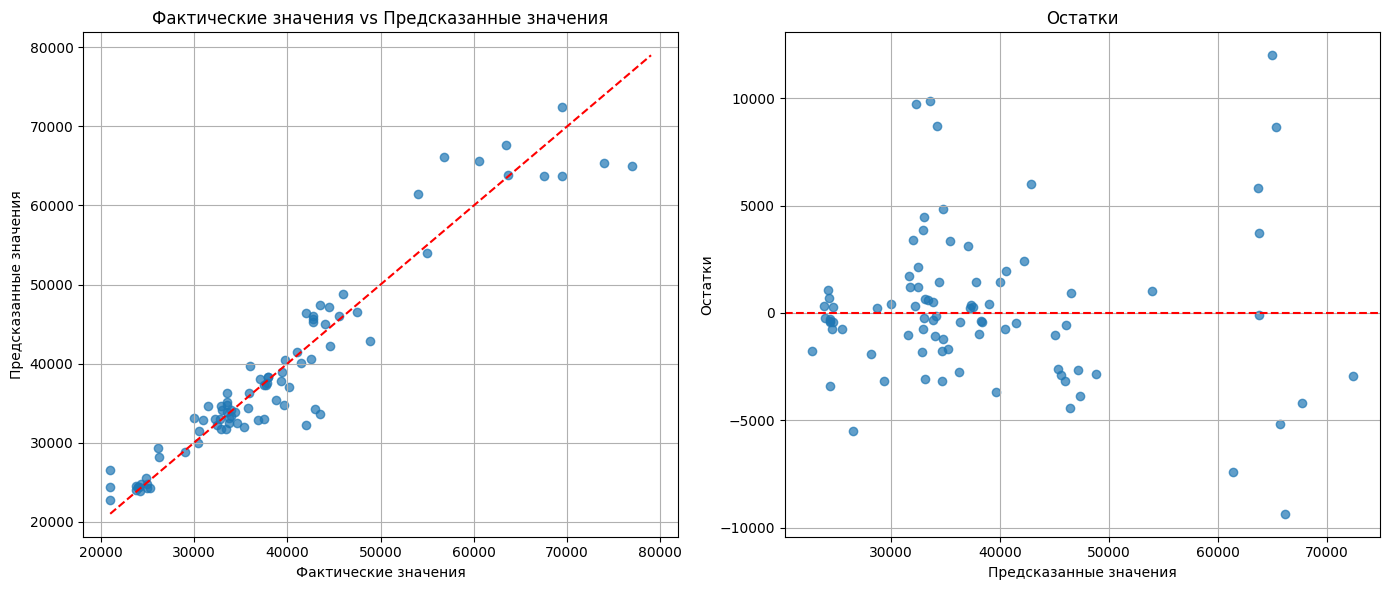

In [14]:

import matplotlib.pyplot as plt

# Визуализация
plt.figure(figsize=(14, 6))

# График фактических значений против предсказанных
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Линия y=x
plt.title('Фактические значения vs Предсказанные значения')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.grid()

# График остатков
residuals = y_test - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Остатки')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.grid()

plt.tight_layout()
plt.show()

Визуализация прогноза

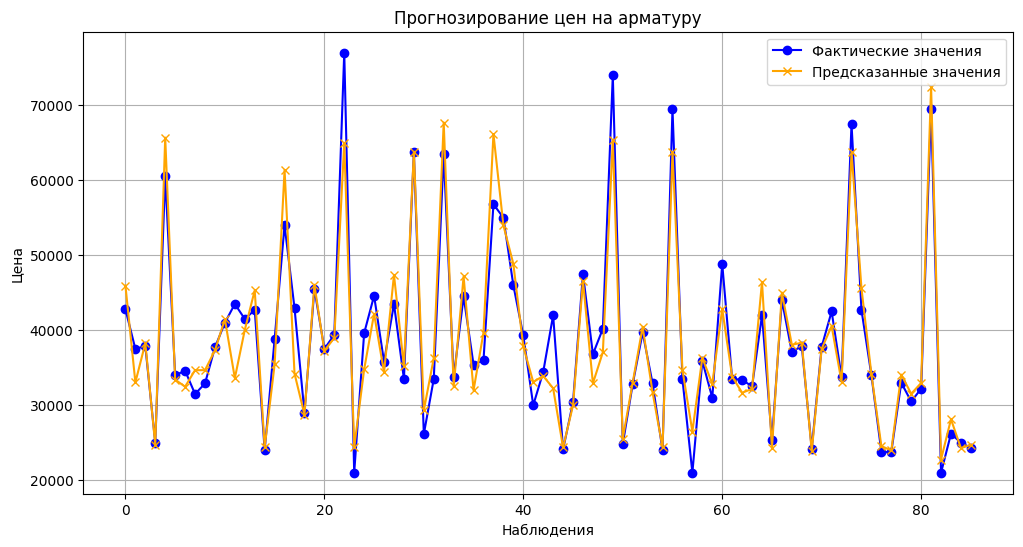

In [15]:
# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(y_test.reset_index(drop=True), label='Фактические значения', color='blue', marker='o')
plt.plot(y_pred, label='Предсказанные значения', color='orange', marker='x')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Наблюдения')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.show()

Сохраняем модель

In [16]:
# Функция для сохранения модели
def save_model(model, filename):
    joblib.dump(model, filename)
    print(f"Модель сохранена в {filename}")

# Сохранение модели
save_model(model, 'random_forest_model.joblib')

Модель сохранена в random_forest_model.joblib


Загружаем обученную модель

In [17]:
# Загрузка предобученной модели
model = joblib.load('random_forest_model.joblib')  # Укажите путь к вашей модели

Прогназируем объем тендера на арматуру

In [23]:
import pandas as pd
from datetime import timedelta
import joblib
import matplotlib.pyplot as plt

# Загрузка предобученной модели
model = joblib.load('random_forest_model.joblib')  # Укажите путь к вашей модели

# Функция для подготовки данных и прогнозирования
def recommend_tender_volume(data, model, N, last_date):
    recommendations = []
    dates = []  # Список для хранения дат предсказаний
    
    # Прогнозируем на N недель вперед
    for i in range(N):
        # Создаем новые признаки на основе last_date
        new_data = pd.DataFrame({
            'Year': [last_date.year],
            'Month': [last_date.month],
            'Day': [last_date.day],
            # Добавьте другие признаки, которые использовались при обучении модели
        })
        
        # Проверка на наличие необходимых признаков
        if not all(col in new_data.columns for col in model.feature_names_in_):
            raise ValueError("Отсутствуют необходимые признаки для предсказания.")
        
        # Прогнозируем объем тендера на следующую неделю
        predicted_volume = model.predict(new_data)
        recommendations.append(predicted_volume[0])  # Сохраняем предсказанное значение
        dates.append(last_date)  # Сохраняем дату предсказания
        
        # Обновление даты для следующей итерации
        last_date += timedelta(weeks=1)
        
    return recommendations, dates

# Пример использования
# Загрузка исторических данных
data = pd.read_csv('combined.csv')  # Укажите путь к вашему CSV файлу

# Укажите количество недель для прогноза
N = 4  # Например, прогноз на 4 недели

# Укажите последнюю дату в ваших данных
last_date = pd.to_datetime('2023-03-13')  # Замените на вашу последнюю дату

# Получение рекомендаций по объему тендера
tender_recommendations, prediction_dates = recommend_tender_volume(data, model, N, last_date)

# Вывод рекомендаций
for week, volume in enumerate(tender_recommendations, start=1):
    print(f"Рекомендация по объему тендера на неделю T+{week}: {volume:.2f}")

Рекомендация по объему тендера на неделю T+1: 53465.00
Рекомендация по объему тендера на неделю T+2: 53839.00
Рекомендация по объему тендера на неделю T+3: 53264.00
Рекомендация по объему тендера на неделю T+4: 52527.00


Визуализируем прогноз

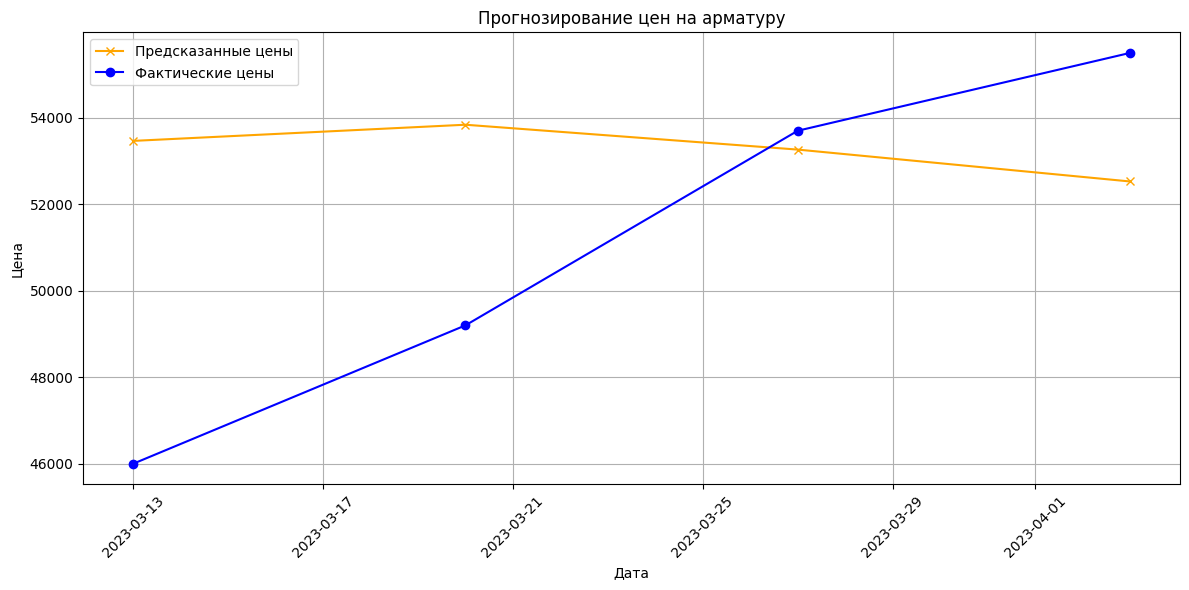

In [24]:
# Визуализация прогноза
plt.figure(figsize=(12, 6))

# Предположим, что в data есть колонка 'price' с фактическими ценами
# Для графика используем последние фактические цены
actual_prices = data['price'].tail(N).reset_index(drop=True)

# Построение графика
plt.plot(prediction_dates, tender_recommendations, label='Предсказанные цены', color='orange', marker='x')
plt.plot(prediction_dates, actual_prices, label='Фактические цены', color='blue', marker='o')

plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Проверяем работу модели

Среднеквадратичная ошибка (MSE): 3815723.57
Коэффициент детерминации (R²): 0.98


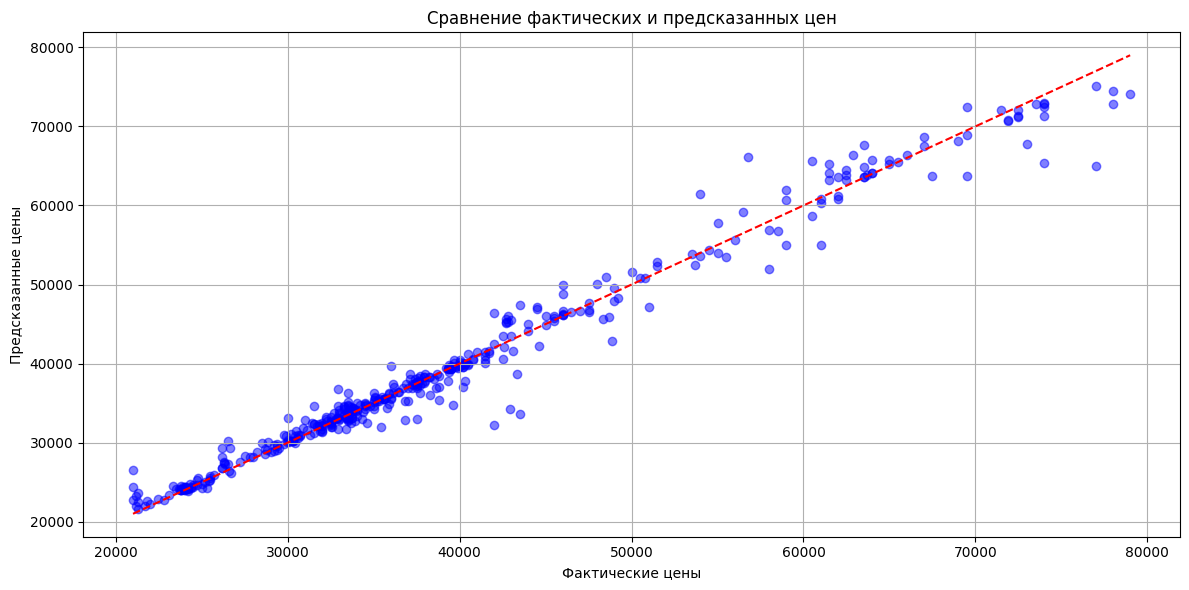

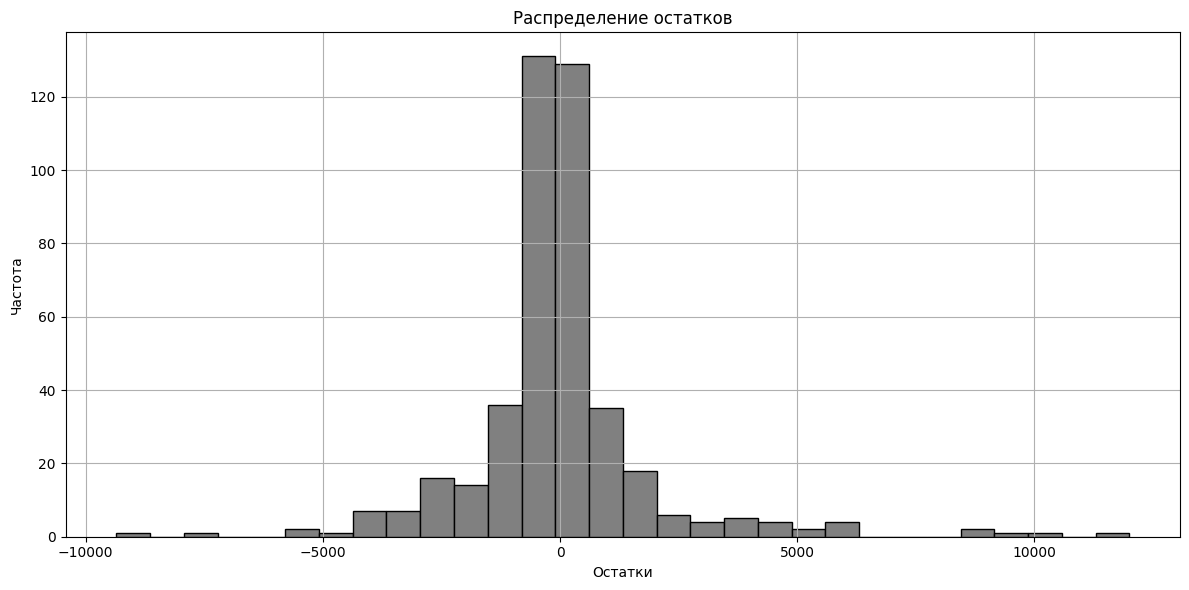

In [2]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Загрузка предобученной модели
model = joblib.load('random_forest_model.joblib')  # Укажите путь к вашей модели

# Загрузка тестового набора данных
test_data = pd.read_csv('combined.csv')  # Укажите путь к вашему тестовому CSV файлу

# Предполагаем, что в test_data есть колонка 'date' с датами
# Если у вас нет колонки 'date', убедитесь, что вы добавили ее
test_data['dt'] = pd.to_datetime(test_data['dt'])  # Преобразование в datetime, если это необходимо

# Извлечение признаков из даты
test_data['Year'] = test_data['dt'].dt.year
test_data['Month'] = test_data['dt'].dt.month
test_data['Day'] = test_data['dt'].dt.day

# Подготовка данных для предсказания
X_test = test_data[['Year', 'Month', 'Day']]  # Убедитесь, что вы используете все необходимые признаки
y_test = test_data['price']  # Предполагаем, что 'price' - это целевая переменная

# Прогнозирование на тестовом наборе данных
y_pred = model.predict(X_test)

# Оценка производительности модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Среднеквадратичная ошибка (MSE): {mse:.2f}')
print(f'Коэффициент детерминации (R²): {r2:.2f}')

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Линия идеального прогноза
plt.title('Сравнение фактических и предсказанных цен')
plt.xlabel('Фактические цены')
plt.ylabel('Предсказанные цены')
plt.grid()
plt.tight_layout()
plt.show()

# Проверка предположений модели (например, нормальность остатков)
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=30, color='gray', edgecolor='black')
plt.title('Распределение остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.grid()
plt.tight_layout()
plt.show()